In [424]:
#importando os pacotes

from sklearn import cluster
from scipy import misc
import time
from scipy.cluster.vq import vq, kmeans, whiten, kmeans2
import PIL
from PIL import Image
import numpy as np
import os, os.path
import matplotlib.pyplot as plt
from matplotlib import image
from os import walk
import matplotlib.image as mpimg
from skimage import color
from skimage import io
import skimage
import copy
import random
from itertools import chain
import statistics as stats
import math
import itertools as it
import colorsys
from PIL import Image
import statistics


%matplotlib inline

In [425]:
files = []

#path = "D:/EMap/TCC/Imagens4/"
path = 'D:/EMap/TCC/Imagens4/PNG/'
for (dirpath, dirnames, filenames) in walk(path):
    files.extend(filenames)
    break
    
files

['01.png', '02.png', '03.png', '04.png', '05.png']

In [426]:
imagens = []
for i in files:
    im = io.imread(path+i)
    imagens.append(im[0:690, 0:1224])
    #im = Image.open(path + i)
    #imagens.append(np.array(im))

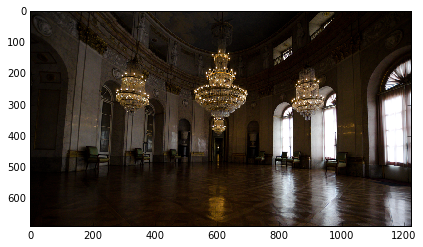

In [427]:
skimage.io.imshow(imagens[2])

In [428]:
imagens[0].shape

(690L, 1224L, 3L)

In [429]:
def SeparaCanais(img):
    Red = img[:,:,0]
    Green = img[:,:,1]
    Blue = img[:,:,2]
    return Red, Green, Blue

In [430]:
Rs = []
Gs = []
Bs = []

for imagem in imagens:
    R,G,B = SeparaCanais(imagem)
    Rs.append(R)
    Gs.append(G)
    Bs.append(B)

In [431]:
Rs[0].shape

(690L, 1224L)

In [432]:
len(Rs)

5

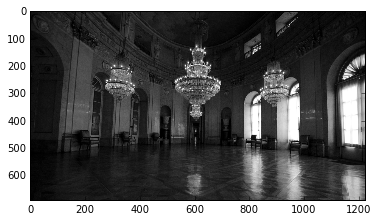

In [433]:
plt.imshow(Rs[2], cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)

#### Gaussian Blur Filter

In [434]:
def G(x, std):
    frac1 = 1./(math.sqrt(2.*math.pi)*std)
    num2 = -(x**2.)
    den2 = 2.*(std**2.)
    frac2 = num2/den2
    return frac1*math.exp(frac2)

In [435]:
def GaussianBlur_notNorm(canal, M, std): #X é a matriz de pixels; M é o tamanho do kernel MxM
    rect_mask = [(i,j)  for j in range(M) for i in range(M)]  
    l = canal[0].shape[0]
    c = canal[0].shape[1]
    loop = [(x,y) for x in xrange(l) for y in xrange(c)]
    list_k = [(i-int(M/2.)) for i in range(M)]
    grid = [(i, j) for i in list_k for j in list_k]
    out_canal = []
    for X in canal:
        out = np.full((l,c), 0.)
        kernel = np.array([G(x, std) for x in list_k])
        for row,col in loop:
            rect = np.full((M,M), 0.)
            neigs = [[(row + i, col + j), e] for e,(i,j) in enumerate(grid) if (0 <= (row + i) <= l-1) and (0 <= (col + j) <= c-1)]
            for p in neigs:
                x_ = p[0][0]
                y_ = p[0][1]
                i = rect_mask[p[1]][0]
                j = rect_mask[p[1]][1]
                rect[i][j] = X[x_][y_]
            f_x = np.dot(rect, kernel)
            f_xy = np.dot(f_x, kernel)
            out[row][col] = f_xy
        out_canal.append(out)
    return out_canal

In [436]:
def GaussianBlur_Norm(canal, M, std): #X é a matriz de pixels; M é o tamanho do kernel MxM
    rect_mask = [(i,j)  for j in range(M) for i in range(M)]  
    l = canal[0].shape[0]
    c = canal[0].shape[1]
    loop = [(x,y) for x in xrange(l) for y in xrange(c)]
    list_k = [(i-int(M/2.)) for i in range(M)]
    grid = [(i, j) for i in list_k for j in list_k]
    out_canal = []
    for X in canal:
        out = np.full((l,c), 0.)
        kernel = np.array([G(x, std) for x in list_k])
        s = np.full((1, kernel.shape[0]), kernel.sum())[0]
        kernel = np.divide(kernel, s)
        for row,col in loop:
            rect = np.full((M,M), 0.)
            neigs = [[(row + i, col + j), e] for e,(i,j) in enumerate(grid) if (0 <= (row + i) <= l-1) and (0 <= (col + j) <= c-1)]
            for p in neigs:
                x_ = p[0][0]
                y_ = p[0][1]
                i = rect_mask[p[1]][0]
                j = rect_mask[p[1]][1]
                rect[i][j] = X[x_][y_]
            f_x = np.dot(rect, kernel)
            f_xy = np.dot(f_x, kernel)
            out[row][col] = f_xy
        out_canal.append(out)
    return out_canal

In [437]:
import copy
Rs_old = copy.deepcopy(Rs)
Gs_old = copy.deepcopy(Gs)
Bs_old = copy.deepcopy(Bs)

In [438]:
'''Rs = GaussianBlur_Norm(Rs, 7, 1.)
Gs = GaussianBlur_Norm(Gs, 7, 1.)
Bs = GaussianBlur_Norm(Bs, 7, 1.)'''

'Rs = GaussianBlur_Norm(Rs, 7, 1.)\nGs = GaussianBlur_Norm(Gs, 7, 1.)\nBs = GaussianBlur_Norm(Bs, 7, 1.)'

In [439]:
from scipy.ndimage.filters import gaussian_filter

for i in xrange(len(Rs)):
    Rs[i] = gaussian_filter(Rs[i], sigma=1.)
    Gs[i] = gaussian_filter(Gs[i], sigma=1.)
    Bs[i] = gaussian_filter(Bs[i], sigma=1.)

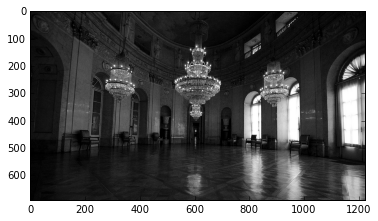

In [440]:
plt.imshow(Rs[2], cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)

#### "Best Candidate Algorithm"

In [601]:
def FindClosest(s, v):
    dist = np.linalg.norm(s[0]-v)
    closest = s[0]
    for i in s[1:]:
        aux = np.linalg.norm(i-v)
        if aux < dist:
            dist = aux
            closest = i
    return closest
        


def sample(w, h, s, numCandidates):
    bestCandidate = np.array((0,0))
    bestDistance = 0
    i = 0
    while i < numCandidates:
        c =  np.array((random.randint(0, w-1), random.randint(0, h-1)))
        d = np.linalg.norm(FindClosest(s, c)-c)
        if d > bestDistance:
            bestDistance = d
            bestCandidate = c
        i += 1
    return bestCandidate


def BestCandidate(img, N):
    rows = img.shape[0]
    cols = img.shape[1]    
    samples = [np.array((random.randint(0, rows-1), random.randint(0, cols-1)))]
    numCand = 10
    while len(samples) < N:
        bestcandidate = sample(rows, cols, samples, numCand)
        #if (img[bestcandidate[0]][bestcandidate[1]] >= 5) & (img[bestcandidate[0]][bestcandidate[1]] <= 250):
        samples.append(bestcandidate)
    return samples

In [602]:
red_pixels = BestCandidate(Rs[4], 500)

In [603]:
green_pixels = BestCandidate(Gs[4], 500)

In [604]:
blue_pixels = BestCandidate(Bs[4], 500)

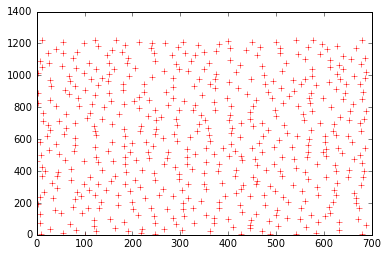

In [605]:
x = []
y = []
for i in red_pixels:
    x.append(i[0])
    y.append(i[1])
    
plt.plot(x, y, 'r+')
plt.show()

In [606]:
def CriaZ(locs_pixels, canal):
    Z = [[] for _ in xrange(len(locs_pixels))]
    for i in xrange(len(locs_pixels)):
        linha = locs_pixels[i][0]
        coluna = locs_pixels[i][1]
        for img in canal:
            Z[i].append(img[linha][coluna])
    return np.array(Z)

In [607]:
#Rs = Rs_old
#Gs = Gs_old
#Bs = Bs_old

Zr = CriaZ(red_pixels, Rs)
Zg = CriaZ(green_pixels, Gs)
Zb = CriaZ(blue_pixels, Bs)

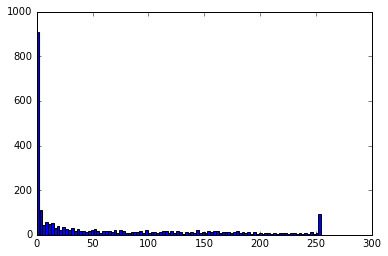

In [608]:
list_red_values = list(chain.from_iterable(list(Zb)))

histo = plt.hist(list_red_values, bins=100)  # plt.hist passes it's arguments to np.histogram
plt.show()

In [609]:
B2 = [1./2500 , 1./640, 1./160, 1./40, 1./10]
B = [math.log(i) for i in B2]
B

[-7.824046010856292,
 -6.461468176353717,
 -5.075173815233827,
 -3.6888794541139363,
 -2.3025850929940455]

In [610]:
def CriaW():
    w = []
    Zmin = 0
    Zmax = 255
    Zmid = round((Zmin+Zmax)/2)
    for z in range(256):
        if z <= Zmid:
            w.append(float(z - Zmin))
        else:
            w.append(float(Zmax - z))
    return w

In [611]:
W = CriaW()

## Algoritmo Debevec

In [612]:
'''Criar um algoritmo que resolve o problema de minimização proposto por debevec, 
montando um sistema de equações no formato Ax = b e resolvendo'''

def AplicaDebevec(Z, B, l, w): #arrays: Z(NxP) ; B(1XP) ; w(1x256) / integer: l
    n = 256
    zlinhas = int(Z.shape[0])
    zcols = int(Z.shape[1])
    
    #construindo A e b  vazios:
    A = np.array([[0.0]*(n+zlinhas)]*(zlinhas*zcols+n+1))
    b = np.array([[0.0]]*len(A))
    
    k=0 ##variavel auxiliar que serve como contador
    
    #compondo a matriz A e o vetor b:
    for i in range(zlinhas):
        for j in range(zcols):
            wij = w[int(Z[i,j])]
            A[k,int(Z[i,j])] = wij
            A[k,(n+i)] = -wij  #-1 pois as posições no python começam no 0
            b[k,0] = float(wij)*B[j]
            k += 1
    
    #igualando Zmid a 0:
    A[k, 128] = 1
    k += 1
    
    #compondo as equações de suavidade:
    for i in range(1,255):
        wi = w[i]
        A[k,(i-1)] = l*wi
        A[k,i] = -(2*l*wi)
        A[k,(i+1)] = l*wi
        k += 1
        
    #resolvendo pela decomposição SVD de A:
    #U, S, V = np.linalg.svd(A)
    #Vt = np.transpose(V)
    #Sinv = np.array([1./i for i in S])
    #Ut = np.transpose(U)
    
    #solução:
    #x = np.dot(Vt, np.dot(Sinv , np.dot(Ut, b)))
    b2 = np.array([float(j[0]) for j in b])
    #b2 = np.array(b2)
    x = np.linalg.lstsq(A,b2)
    x2 =  [float(j) for j in x[0]]
    g = x2[0:n]
    lE = x2[n:len(x2)]
    
    return g, lE
        
        

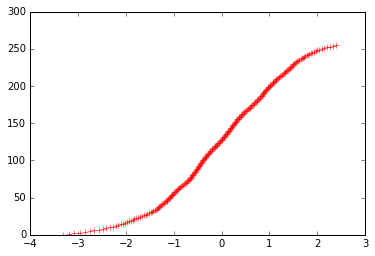

In [651]:
#gR, lER = AplicaDebevec(Zr, B, 80., W)
gR, lER = AplicaDebevec(Zr, B, 30., W)


plt.plot(gR, range(256),'r+')

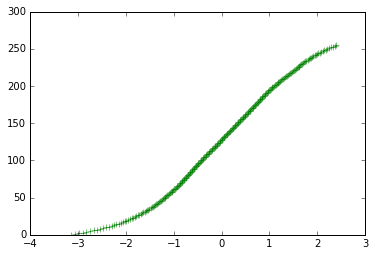

In [652]:
#gG, lEG = AplicaDebevec(Zg, B, 80., W)
gG, lEG = AplicaDebevec(Zg, B, 80., W)

plt.plot(gG, range(256),'g+')

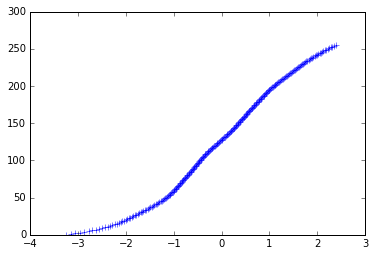

In [653]:
gB, lEB = AplicaDebevec(Zb, B, 50., W)#80

plt.plot(gB, range(256),'b+')

#### Formando a matriz de irradiância Ei da imagem HDR (para cada um dos três canais R, G e B):

In [654]:
def Calcula_GeW(w,g,z,col,row):
    out_w = np.array([[0.0]*col]*row)
    out_g = np.array([[0.0]*col]*row)
    for i in range(row):
        for j in range(col):
            aux_w = float(w[int(z[i][j])])
            if aux_w==0.0:
                out_w[i][j] = 0.001
            else:
                out_w[i][j] = aux_w
            out_g[i][j] = float(g[int(z[i][j])])
    return out_g, out_w

def CriaHDR(w,b,g,imgs):
    l = int(imgs[0].shape[0])
    c = int(imgs[0].shape[1])
    hdr = np.array([[0.0]*c]*l)
    soma_w = np.array([[0.0]*c]*l)
    for i in range(len(imgs)):
        gj, wj = Calcula_GeW(w,g,imgs[i],c,l)
        aux = np.multiply(wj, np.subtract(gj, b[i]))
        hdr = np.add(hdr, aux)
        soma_w = np.add(soma_w,wj)
    verifica_w = np.where(soma_w == 0)
    len_verifica = int(verifica_w[0].size)
    if len_verifica != 0:
        print('Problema!')
        for i in range(len_verifica):
            soma_w[verifica_w[0][i]][verifica_w[1][i]] = 1.0
    hdr = np.divide(hdr, soma_w)
    e = np.full((l, c), math.exp(1))
    hdr = np.power(e, hdr)
    return hdr
    #return soma_w

In [655]:
#red_HDR = CriaHDR(W,B,gR_new,Rs)
red_HDR = CriaHDR(W,B,gR,Rs_old)

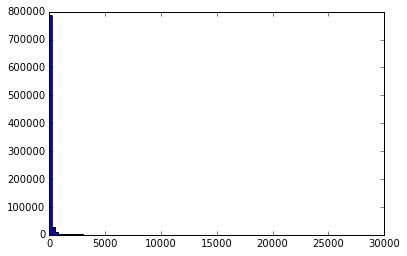

In [656]:
hdr_red_values = list(chain.from_iterable(list(red_HDR)))

plt.hist(hdr_red_values, bins=100)  # plt.hist passes it's arguments to np.histogram
plt.show()

In [657]:
max(hdr_red_values)

25112.19309996365

In [658]:
#green_HDR = CriaHDR(W,B,gG_new,Gs)
green_HDR = CriaHDR(W,B,gG,Gs_old)

In [659]:
green_HDR.max()

26119.050831261382

In [660]:
#blue_HDR = CriaHDR(W,B,gB_new,Bs)
blue_HDR = CriaHDR(W,B,gB,Bs_old)

In [661]:
blue_HDR.max()

22820.184134177354

## Obtendo a luminância através da transformação YUV

In [662]:
def JuntaCanais(r,g,b):
    r  = r.reshape((r.shape[0], r.shape[1], 1))
    g  = g.reshape((g.shape[0], g.shape[1], 1))
    b  = b.reshape((b.shape[0], b.shape[1], 1))
    
    rgb = np.concatenate((r, g, b), axis=2)
    
    return rgb

In [663]:
def myRGBtoY(rgb):
    t2 = np.array([0.2126,0.7152,0.0722])
    #t2 = np.array([0.299,0.587,0.114])
    y = np.dot(rgb[...,:3], t2)
    
    return y

In [664]:
Y_ = myRGBtoY(JuntaCanais(red_HDR, green_HDR, blue_HDR))

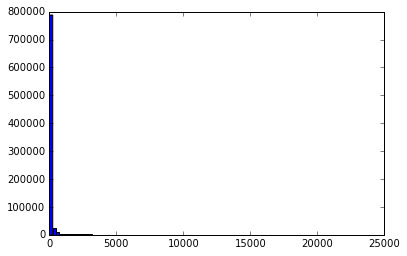

In [665]:
hdr_red_values = list(chain.from_iterable(list(Y_)))

plt.hist(hdr_red_values, bins=100)  # plt.hist passes it's arguments to np.histogram
plt.show()

### Algoritmo de Tone Mapping: artigo Duan (2008)

In [666]:
def HDRduan_part1(L, t): #L eh o vetor com todas as luminancias, t é um parametro da funcao
    #L_list = list(chain.from_iterable(list(L)))
    Lmin = L.min()
    Lmax = L.max()
    row = L.shape[0]
    c = L.shape[1]
    Lnew = np.full((row, c), 0.)
    for i in range(row):
        for j in range(c):
            l = L[i][j]
            numerador = math.log(l + t) - math.log(Lmin + t)
            denominador = math.log(Lmax + t) - math.log(Lmin + t)
            #frac = round(255.*(numerador/denominador))
            frac = int(255*(numerador/denominador))
            Lnew[i][j] = frac
    return Lnew

In [667]:
newY1 = HDRduan_part1(Y_, 0.5)

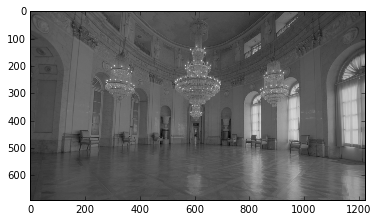

In [668]:
plt.imshow(newY1, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)

## TMO Global

In [669]:
def EncontraLn(Dmin, Dmax):
    Ln = (Dmax + Dmin)/2
    return Ln


def EncontraEn(list_pixels):
    En = statistics.median(list_pixels)
    return float(En)


def EncontraLEn(beta, list_pixels_min_max, lmin, lmax):
    ln = EncontraLn(lmin, lmax)
    en = EncontraEn(list_pixels_min_max)
    LEn = ln + beta*(en-ln)
    ints = [(lmin, LEn), (LEn, lmax)]
    return ints


def find_list(lst, a, b):
    out = []
    c = 0
    for i in lst:
        if (a<=i) & (i<=b):
            out.append(i)
    return out

In [670]:
def Duan_HALEQ_vs3(beta, img):
    list_pixels_img = sorted(list(chain.from_iterable(list(img))))
    #aux1 = []
    min_val = min(list_pixels_img)
    max_val = max(list_pixels_img)
    aux2 = [((min_val, max_val), list_pixels_img)]
    num_ints = math.ceil(max_val) - math.ceil(min_val) + 1
    counter = 0
    i = 0
    while ((len(aux2) != num_ints) and (i != 10000)):
        j = aux2.pop(0)
        if (j[0][0] == j[0][1]):
            aux2.append((j[0],j[0]))
            continue
        else:
            if j[1] == []:
                aux2.append([(j[0][0], j[0][1]),[]])
                continue
            else:
                list_pixels_min_max = find_list(j[1], j[0][0], j[0][1])
                if list_pixels_min_max == []:
                    aux2.append([(j[0][0], j[0][1]),[]])
                    continue
                else:
                    bins = EncontraLEn(beta, list_pixels_min_max, j[0][0], j[0][1])
                    aux2.append((bins[0], list_pixels_min_max))
                    aux2.append((bins[1], list_pixels_min_max))
        i += 1
    out = []
    out2 = []
    for k in xrange(len(aux2)):
        out.append([aux2[k][0], k])
    out = sorted(out)
    C = 0
    for j in xrange(len(out)):
        if (aux2[out[j][1]][1] == []):
            if (j != 0):
                out2[C-1] = (out2[C-1][0], out[j][0][1])
            else:
                print('LISTA VAZIA NO PRIMEIRO ELEMENTO - VER HALEQ PART.1')
        else:
            out2.append(out[j][0])
            C = C + 1
    return sorted(out2)

In [671]:
ints_hdr_duan1 = Duan_HALEQ_vs3(0.5, newY1)

In [672]:
def subs_groups_duan(ints, img):
    k = round(ints[0][0])
    groups = []
    for i in ints:
        groups.append([i, k])
        k += 1
    l = img.shape[0]
    c = img.shape[1]
    aux_1D = img.flatten('C')
    new = aux_1D.copy()
    for i in groups:
        x = np.where(((aux_1D >= i[0][0]) & (aux_1D < i[0][1])))
        pos = x[0].tolist()
        new[pos] = i[1]
    return new.reshape((l, c), order='C') #, groups

In [673]:
HDR_global = subs_groups_duan(ints_hdr_duan1, newY1)

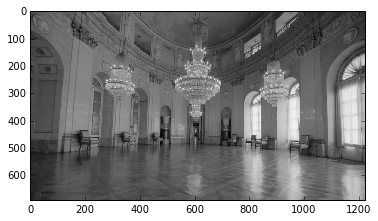

In [674]:
plt.imshow(HDR_global, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)

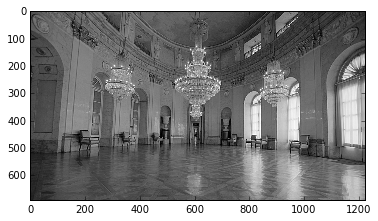

In [675]:
def sharpen_img(img, alpha):
    #blurred_img = GaussianBlur_Norm([img], 7, 1.)[0]
    blurred_img = gaussian_filter(img, sigma=2.)
    sharpened = np.add(img,np.multiply(alpha,np.subtract(img,blurred_img)))
    return sharpened

lum_final_global = sharpen_img(HDR_global, 1.)

plt.imshow(lum_final_global, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)
plt.show()

### TMO Local

In [676]:
def Duan_HALEQ_vs3_adap(beta, img): #img é array 1D
    list_pixels_img = sorted(img.tolist())
    #aux1 = []
    min_val = min(list_pixels_img)
    max_val = max(list_pixels_img)
    aux2 = [((min_val, max_val), list_pixels_img)]
    num_ints = math.ceil(max_val) - math.ceil(min_val) + 1
    counter = 0
    i = 0
    while ((len(aux2) != num_ints) and (i != 10000)):
        j = aux2.pop(0)
        if (j[0][0] == j[0][1]):
            aux2.append((j[0],j[0]))
            continue
        else:
            if j[1] == []:
                aux2.append([(j[0][0], j[0][1]),[]])
                continue
            else:
                list_pixels_min_max = find_list(j[1], j[0][0], j[0][1])
                if list_pixels_min_max == []:
                    aux2.append([(j[0][0], j[0][1]),[]])
                    continue
                else:
                    bins = EncontraLEn(beta, list_pixels_min_max, j[0][0], j[0][1])
                    aux2.append((bins[0], list_pixels_min_max))
                    aux2.append((bins[1], list_pixels_min_max))
        i += 1
    out = []
    out2 = []
    for k in xrange(len(aux2)):
        out.append([aux2[k][0], k])
    out = sorted(out)
    C = 0
    for j in xrange(len(out)):
        if (aux2[out[j][1]][1] == []):
            if (j != 0):
                out2[C-1] = (out2[C-1][0], out[j][0][1])
            else:
                print('LISTA VAZIA NO PRIMEIRO ELEMENTO - VER HALEQ PART.1')
        else:
            out2.append(out[j][0])
            C = C + 1
    return sorted(out2)

In [677]:
'''def DefineBeta_adap(arr_1D, bin_number, beta):
    hist, bin_edges = np.histogram(arr_1D, bins=bin_number)
    m = hist.mean()
    print(m)
    s = 0.
    for j in hist:
        s = s + float(abs(j - m))
    SD = s/float(bin_number)
    print(SD)
    if SD >= 17.:
        if SD > 20:
            SD = 20.
        new_beta = beta*(1. - math.exp(-(20.-SD)))
    else:
        new_beta = beta
    return new_beta'''

'def DefineBeta_adap(arr_1D, bin_number, beta):\n    hist, bin_edges = np.histogram(arr_1D, bins=bin_number)\n    m = hist.mean()\n    print(m)\n    s = 0.\n    for j in hist:\n        s = s + float(abs(j - m))\n    SD = s/float(bin_number)\n    print(SD)\n    if SD >= 17.:\n        if SD > 20:\n            SD = 20.\n        new_beta = beta*(1. - math.exp(-(20.-SD)))\n    else:\n        new_beta = beta\n    return new_beta'

In [678]:
def subs_groups_duan_adap(ints, img_1D):
    k = int(round(ints[0][0]))
    groups = []
    for i in ints:
        groups.append([i, k])
        k += 1
    new = img_1D.copy()
    for i in groups:
        x = np.where(((img_1D >= i[0][0]) & (img_1D < i[0][1])))
        pos = x[0].tolist()
        new[pos] = i[1]
    return new, groups

In [679]:
def haleq_local_Kmeans(img, n_clusters, beta): 
    #start_time = time.time()
    
    l = img.shape[0]
    c = img.shape[1]
    new_HDR = np.full((l,c), 0.)
    
    X = img.reshape((-1, 1))
    labels_arr = kmeans2(X,n_clusters)[1]
    clusters = list(set(labels_arr))
    labels_arr.shape = img.shape
    #print("--- %s seconds ---" % (time.time() - start_time))
    
    for i in clusters:
        pos = np.where(labels_arr == i)
        Aux = img[pos[0],pos[1]]
        #n_beta = DefineBeta_adap(Aux, 20, beta)
        ints = Duan_HALEQ_vs3_adap(beta, Aux)
        new_Aux, group = subs_groups_duan_adap(ints, Aux)
        loop = zip(pos[0], pos[1])
        e = 0
        for i in loop:
                new_HDR[i[0]][i[1]] = new_Aux[e]
                e += 1
            
    return new_HDR

In [692]:
HDR_local = haleq_local_Kmeans(newY1, 10, 0.7) #beta = 0.5

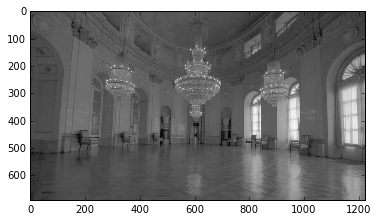

In [693]:
plt.imshow(HDR_local, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)

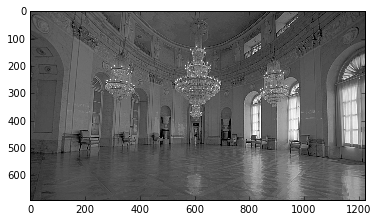

In [694]:
lum_final_local = sharpen_img(HDR_local, 1.5)

plt.imshow(lum_final_local, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)
plt.show()

## Resultados:

In [684]:
def ColorOut(Cin, Lin, Lout, s):
    aux1 = np.divide(Cin, Lin)
    aux2 = np.power(aux1, s)
    Cout = np.multiply(aux2, Lout)
    l = Cout.shape[0]
    c = Cout.shape[1]
    out = Cout.flatten('C')
    for i in xrange(len(out)):
        out[i] = min(max(0.,round(out[i])), 255)
    return out.reshape((l, c), order='C')


def ColorOut2(Cin, Lin, Lout, s):
    aux1 = np.divide(Cin, Lin)
    aux2 = np.power(aux1, s)
    Cout = np.multiply(aux2, Lout)
    l = Cout.shape[0]
    c = Cout.shape[1]
    out = Cout.flatten('C')
    for i in xrange(len(out)):
        out[i] = min(max(30.,round(out[i])), 200)
    return out.reshape((l, c), order='C')

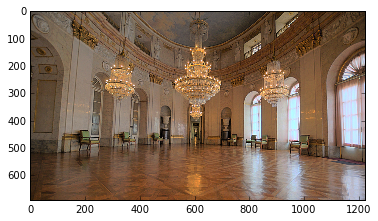

In [685]:
Rnew = ColorOut(red_HDR, Y_, lum_final_global, 0.7)
Gnew = ColorOut(green_HDR, Y_, lum_final_global, 0.7)
Bnew = ColorOut(blue_HDR, Y_, lum_final_global, 0.7)

RGBnew = JuntaCanais(Rnew,Gnew,Bnew)
RGB_new_vs1 = np.array(RGBnew, dtype=np.uint8)

plt.imshow(RGB_new_vs1)
plt.show()

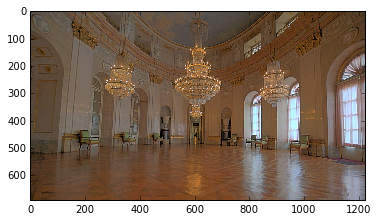

In [695]:
Rnew = ColorOut(red_HDR, Y_, lum_final_local, 0.7)
Gnew = ColorOut(green_HDR, Y_, lum_final_local, 0.7)
Bnew = ColorOut(blue_HDR, Y_, lum_final_local, 0.7)

RGBnew = JuntaCanais(Rnew,Gnew,Bnew)
RGB_new_vs2 = np.array(RGBnew, dtype=np.uint8)

plt.imshow(RGB_new_vs2)
plt.show()

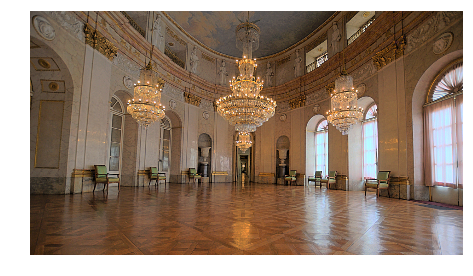

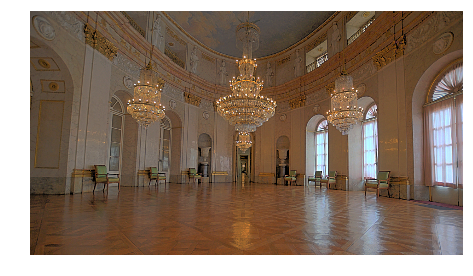

In [696]:
fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(RGB_new_vs1)
plt.show()
fig.savefig("D:/EMap/TCC/corrigir_gimp/versoes_finais/imagens4_ESP_vs9_wglobalTMO_wGaussianB_7_1.png",dpi=600)
plt.close()

fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(RGB_new_vs2)
plt.show()
fig.savefig("D:/EMap/TCC/corrigir_gimp/versoes_finais/imagens4_ESP_vs9_wlocalTMO_wGaussianB_7_1.png",dpi=600)
plt.close()